## MA5852 Assessment 2 - Cloud Computing
### Notebook 1 - Data preprocessing and splitting

#### Part 0: Notebook preparation

In [1]:
%%sh
ls -l

total 21636
-rw-rw-r-- 1 ec2-user ec2-user     5875 May 29 05:55 A2_NN model script.py
-rw-rw-r-- 1 ec2-user ec2-user    70379 May 30 05:05 A2 Notebook 1.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 22052158 May 29 14:33 A2 Notebook 2.ipynb
drwxrwxr-x 3 ec2-user ec2-user     4096 May 28 11:55 data
drwx------ 2 ec2-user ec2-user    16384 May 28 07:20 lost+found


In [ ]:
%%sh
sudo chown ec2-user lost+found

%%sh
sudo chgrp ec2-user lost+found

%%sh
ls -l 

In [1]:
# import necessary libraries and define environment variables
# Sagemaker
import sagemaker
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

# Part 1 libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Part 2 libraries
from sklearn.preprocessing import StandardScaler

In [ ]:
# create the required directories
os.makedirs("./data/A2", exist_ok=True)

In [2]:
# upload the data using the upload button and then read it in
diabetes_data = pd.read_csv("./data/A2/diabetic_data.csv")

# obtain some initial dataset stats
diabetes_data.info()
diabetes_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


#### Part 1: Pre-processing the data

In [3]:
# create a copy so can go back to the original dataset if required
diabetes_data2 = diabetes_data.copy()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

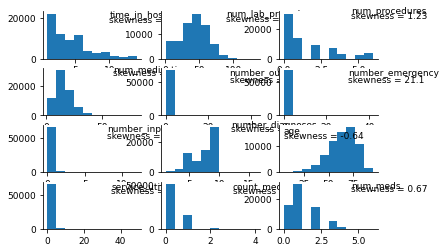

In [4]:
# replace '?' with np.nan to count number of missing values
diabetes_data2 = diabetes_data2.replace('?', np.nan)
print(diabetes_data2.isnull().sum())

# remove weight and payer_code
diabetes_data2.drop(['weight', 'payer_code'], axis=1, inplace=True)

# sort by patient_nbr and encounter_id and remove duplicate records
diabetes_data2 = diabetes_data2.sort_values(by=['patient_nbr', 'encounter_id'])
diabetes_data2.drop_duplicates(subset='patient_nbr', keep='first', inplace=True)

# replace missing values with 'Unknown', group the records by medical specialty and then consolidate
med_spec = diabetes_data2.groupby('medical_specialty').size().reset_index()
diabetes_data2['medical_specialty2'] = diabetes_data2.medical_specialty.copy()
diabetes_data2.medical_specialty2.fillna('Unknown', inplace=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Anesth.*', "Anesthesiology", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Cardio.*', "Cardiology", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Endo.*', "Endocrinology", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^(Hema.*|Onc.*)', "Hematology/Oncology", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^(Obst.*|Gyne.*)', "Obstetrics/Gynecology", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Ortho.*', "Orthopedics", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Ped.*', "Pediatrics", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Psych.*', "Psychiatry", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^Radio.*', "Radiology", regex=True)
diabetes_data2.medical_specialty2 = diabetes_data2.medical_specialty2.str.replace(r'^(Surgeon|Surgery).*', "Surgery", regex=True)
med_spec2 = diabetes_data2.groupby('medical_specialty2').size().sort_values(ascending=False)
top_med_specs = ['Unknown', 'InternalMedicine', 'Family/GenderPractice', 'Emergency/Trauma', 'Cardiology', 'Surgery', 'Orthopedics']

diabetes_data2['medical_specialty2'] = diabetes_data2.medical_specialty.copy()
diabetes_data2.loc[~diabetes_data2.medical_specialty2.isin(top_med_specs), 'medical_specialty2'] = 'Other'

# consolidate diag_1, diag_2 and diag_3 based on 2013 ICD-9 diagnosis codes
diabetes_data2['diag_1_2'] = diabetes_data2.diag_1.copy()
diabetes_data2['diag_2_2'] = diabetes_data2.diag_2.copy()
diabetes_data2['diag_3_2'] = diabetes_data2.diag_3.copy()

diabetes_data2.diag_1_2 = diabetes_data2.diag_1.str.replace(r'^(39.*|40.*|41.*|42.*|43.*|44.*|45.*|785)', "Circulatory", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^(46.*|47.*|48.*|49.*|50.*|51.*|786)', "Respiratory", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^(52.*|53.*|54.*|55.*|56.*|57.*|787)', "Digestive", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^250\..*', "Diabetes", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^(8.*|9.*)', "Injury", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^(71.*|72.*|73.*)', "Musculoskeletal", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^(58.*|59.*|60.*|61.*|62.*|788)', "Genitourinary", regex=True)
diabetes_data2.diag_1_2 = diabetes_data2.diag_1_2.str.replace(r'^(14.*|15.*|16.*|17.*|18.*|19.*|20.*|21.*|22.*|23.*)', "Neoplasms", regex=True)
diabetes_data2.diag_1_2.fillna('Unknown', inplace=True)

diabetes_data2.diag_2_2 = diabetes_data2.diag_2.str.replace(r'^(39.*|40.*|41.*|42.*|43.*|44.*|45.*|785)', "Circulatory", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^(46.*|47.*|48.*|49.*|50.*|51.*|786)', "Respiratory", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^(52.*|53.*|54.*|55.*|56.*|57.*|787)', "Digestive", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^250\..*', "Diabetes", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^(8.*|9.*)', "Injury", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^(71.*|72.*|73.*)', "Musculoskeletal", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^(58.*|59.*|60.*|61.*|62.*|788)', "Genitourinary", regex=True)
diabetes_data2.diag_2_2 = diabetes_data2.diag_2_2.str.replace(r'^(14.*|15.*|16.*|17.*|18.*|19.*|20.*|21.*|22.*|23.*)', "Neoplasms", regex=True)
diabetes_data2.diag_2_2.fillna('Unknown', inplace=True)

diabetes_data2.diag_3_2 = diabetes_data2.diag_3.str.replace(r'^(39.*|40.*|41.*|42.*|43.*|44.*|45.*|785)', "Circulatory", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^(46.*|47.*|48.*|49.*|50.*|51.*|786)', "Respiratory", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^(52.*|53.*|54.*|55.*|56.*|57.*|787)', "Digestive", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^250\..*', "Diabetes", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^(8.*|9.*)', "Injury", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^(71.*|72.*|73.*)', "Musculoskeletal", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^(58.*|59.*|60.*|61.*|62.*|788)', "Genitourinary", regex=True)
diabetes_data2.diag_3_2 = diabetes_data2.diag_3_2.str.replace(r'^(14.*|15.*|16.*|17.*|18.*|19.*|20.*|21.*|22.*|23.*)', "Neoplasms", regex=True)
diabetes_data2.diag_3_2.fillna('Unknown', inplace=True)

diag_1 = diabetes_data2.groupby('diag_1_2').size().sort_values(ascending=False)
top_diag = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury', 'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Unknown']

diabetes_data2.loc[~diabetes_data2.diag_1_2.isin(top_diag), 'diag_1_2'] = 'Other'
diabetes_data2.loc[~diabetes_data2.diag_2_2.isin(top_diag), 'diag_2_2'] = 'Other'
diabetes_data2.loc[~diabetes_data2.diag_3_2.isin(top_diag), 'diag_3_2'] = 'Other'
diabetes_data2.gender = diabetes_data2.gender.replace('Unknown/Invalid', np.nan)

# convert age into a numeric feature by mapping to the mid-point of each category range
numeric_age = {'[0-10)': 5,
               '[10-20)': 15,
               '[20-30)': 25,
               '[30-40)': 35,
               '[40-50)': 45,
               '[50-60)': 55,
               '[60-70)': 65,
               '[70-80)': 75,
               '[80-90)': 85,
               '[90-100)': 95}
diabetes_data2['age2'] = diabetes_data2.age.replace(numeric_age)

# re-define readmitted as a binary classification feature, where 1 indicates the patient was readmitted and 0 otherwise
multi_outcome_nums = diabetes_data2.readmitted.value_counts()
diabetes_data2['readmitted2'] = (diabetes_data2.readmitted != 'NO').astype('int')

# create three new feature columns to reduce information loss due to dropping medication variables
diabetes_data2['service_utilisation'] = diabetes_data2.number_emergency + diabetes_data2.number_outpatient + diabetes_data2.number_inpatient

med_change = {'Up', 'Down'}
med_count = {'Steady', 'Up', 'Down'}
diabetes_data2['count_med_change'] = diabetes_data2.isin(med_change).sum(1)
diabetes_data2['num_meds'] = diabetes_data2.isin(med_count).sum(1)

# drop any columns no longer required
diabetes_data2.drop(['encounter_id', 'patient_nbr', 'age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'readmitted'], inplace=True, axis=1)
diabetes_data2.drop(diabetes_data2.iloc[:, 15:32], inplace=True, axis=1)
diabetes_data2.drop(diabetes_data2.iloc[:, 16:21], inplace=True, axis=1)

# rename columns
diabetes_data2.rename(columns={'medical_specialty2': 'medical_specialty',
                               'diag_1_2': 'diag_1',
                               'diag_2_2': 'diag_2',
                               'diag_3_2': 'diag_3',
                               'age2': 'age',
                               'readmitted2': 'readmitted'}, inplace=True)

# drop observations meeting the following conditions
# any records with discharge ids related to death or a hospice as they will never be readmitted
# listwise deletion of any records with missing values
diabetes_data2 = diabetes_data2.loc[~diabetes_data2.discharge_disposition_id.isin([11, 13, 14, 19, 20, 21])]
diabetes_data2 = diabetes_data2.dropna()

# re-calculate number of records readmitted
# observe that the dataset is very imbalanced, which will need to be addressed
binary_outcome_nums = diabetes_data2.readmitted.value_counts()


def calc_prevalence(y_actual):
    return sum(y_actual)/len(y_actual)


print('Prevalence:%.3f' % calc_prevalence(diabetes_data2['readmitted'].values))

# one-hot-encode all categorical variables and add them back to the dataframe
cols_num = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses', 'age', 'service_utilisation',
            'count_med_change', 'num_meds']

cols_cat = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medical_specialty',
            'diag_1', 'diag_2', 'diag_3']

cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

cols_outcome = ['readmitted']

diabetes_data2[cols_cat_num] = diabetes_data2[cols_cat_num].astype('str')

diabetes_cat = pd.get_dummies(diabetes_data2[cols_cat + cols_cat_num], drop_first=True)

diabetes_data2 = pd.concat([diabetes_data2, diabetes_cat], axis=1)
cols_all_cat = list(diabetes_cat.columns)

# apply log or sqrt transformations to reduce skewness and add variables back into the dataframe
plt.rcParams.update({'font.size': 9})
fig, axs = plt.subplots(4,3)
axs[0,0].hist(diabetes_data2.time_in_hospital)
axs[0,0].annotate(cols_num[0], (10,20000))
axs[0,0].annotate("skewness = "+str(round(diabetes_data2.time_in_hospital.skew(), 2)), (10,18000))
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)
axs[0,1].hist(diabetes_data2.num_lab_procedures)
axs[0,1].annotate(cols_num[1], (90,17000))
axs[0,1].annotate("skewness = "+str(round(diabetes_data2.num_lab_procedures.skew(), 2)), (90,15000))
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)
axs[0,2].hist(diabetes_data2.num_procedures)
axs[0,2].annotate(cols_num[2], (4.5,30000))
axs[0,2].annotate("skewness = "+str(round(diabetes_data2.num_procedures.skew(), 2)), (4.5,27000))
axs[0,2].spines['right'].set_visible(False)
axs[0,2].spines['top'].set_visible(False)
axs[1,0].hist(diabetes_data2.num_medications)
axs[1,0].annotate(cols_num[3], (60,30000))
axs[1,0].annotate("skewness = "+str(round(diabetes_data2.num_medications.skew(),2)), (60,27000))
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,1].hist(diabetes_data2.number_outpatient)
axs[1,1].annotate(cols_num[4], (30,60000))
axs[1,1].annotate("skewness = "+str(round(diabetes_data2.number_outpatient.skew(),2)), (30,50000))
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,2].hist(diabetes_data2.number_emergency)
axs[1,2].annotate(cols_num[5], (30,60000))
axs[1,2].annotate("skewness = "+str(round(diabetes_data2.number_emergency.skew(),2)), (30,50000))
axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['top'].set_visible(False)
axs[2,0].hist(diabetes_data2.number_inpatient)
axs[2,0].annotate(cols_num[6], (8,60000))
axs[2,0].annotate("skewness = "+str(round(diabetes_data2.number_inpatient.skew(),2)), (8,50000))
axs[2,0].spines['right'].set_visible(False)
axs[2,0].spines['top'].set_visible(False)
axs[2,1].hist(diabetes_data2.number_diagnoses)
axs[2,1].annotate(cols_num[7], (12,30000))
axs[2,1].annotate("skewness = "+str(round(diabetes_data2.number_diagnoses.skew(),2)), (12,27000))
axs[2,1].spines['right'].set_visible(False)
axs[2,1].spines['top'].set_visible(False)
axs[2,2].hist(diabetes_data2.age)
axs[2,2].annotate(cols_num[8], (5,15000))
axs[2,2].annotate("skewness = "+str(round(diabetes_data2.age.skew(),2)), (5,13000))
axs[2,2].spines['right'].set_visible(False)
axs[2,2].spines['top'].set_visible(False)
axs[3,0].hist(diabetes_data2.service_utilisation)
axs[3,0].annotate(cols_num[9], (35,60000))
axs[3,0].annotate("skewness = "+str(round(diabetes_data2.service_utilisation.skew(),2)), (35,53000))
axs[3,0].spines['right'].set_visible(False)
axs[3,0].spines['top'].set_visible(False)
axs[3,1].hist(diabetes_data2.count_med_change)
axs[3,1].annotate(cols_num[10], (3,45000))
axs[3,1].annotate("skewness = "+str(round(diabetes_data2.count_med_change.skew(),2)), (3,40000))
axs[3,1].spines['right'].set_visible(False)
axs[3,1].spines['top'].set_visible(False)
axs[3,2].hist(diabetes_data2.num_meds)
axs[3,2].annotate(cols_num[11], (4.5,28000))
axs[3,2].annotate("skewness = "+str(round(diabetes_data2.num_meds.skew(),2)), (4.5,25000))
axs[3,2].spines['right'].set_visible(False)
axs[3,2].spines['top'].set_visible(False)
plt.show()

cols_num_log = ['time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
                'number_inpatient', 'service_utilisation', 'count_med_change']

cols_num_sqrt = ['number_diagnoses', 'num_meds']

cols_num_none = ['num_lab_procedures', 'age']

diabetes_log = diabetes_data2[cols_num_log].applymap(lambda x: np.log(x+1))
diabetes_sqrt = diabetes_data2[cols_num_sqrt].applymap(lambda x: np.sqrt(x+1))

diabetes_log.columns = 'log_' + diabetes_log.columns
diabetes_sqrt.columns = 'sqrt_' + diabetes_sqrt.columns

cols_num_log = diabetes_log.columns.tolist()
cols_num_sqrt = diabetes_sqrt.columns.tolist()

diabetes_data3 = pd.concat([diabetes_data2, diabetes_log, diabetes_sqrt], axis=1)

# create the final dataset
cols2use = cols_num_log + cols_num_sqrt + cols_num_none + cols_all_cat + cols_outcome
diabetes_data_final_full = diabetes_data3[cols2use]

In [5]:
# check that everything has run correctly
diabetes_data_final_full.info()
diabetes_data_final_full.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68054 entries, 4267 to 96147
Columns: 103 entries, log_time_in_hospital to readmitted
dtypes: float64(10), int64(3), uint8(90)
memory usage: 13.1 MB


,log_time_in_hospital,log_num_procedures,log_num_medications,log_number_outpatient,log_number_emergency,log_number_inpatient,log_service_utilisation,log_count_med_change,sqrt_number_diagnoses,sqrt_num_meds,...,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,readmitted
count,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,...,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000
mean,1.520138,0.655017,2.694016,0.135146,0.061626,0.102014,0.270875,0.177272,2.846076,1.444626,...,0.000059,0.000029,0.001998,0.034722,0.007435,0.022908,0.537323,0.000162,0.000573,0.410307
std,0.532677,0.664448,0.502871,0.381582,0.231212,0.297463,0.506039,0.313791,0.374287,0.317291,...,0.007666,0.005421,0.044659,0.183077,0.085907,0.149612,0.498609,0.012713,0.023932,0.491893
min,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.414214,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.098612,0.000000,2.397895,0.000000,0.000000,0.000000,0.000000,0.000000,2.645751,1.414214,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.386294,0.693147,2.708050,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.414214,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.945910,1.098612,3.044522,0.000000,0.000000,0.000000,0.693147,0.000000,3.162278,1.732051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.708050,1.945910,4.406719,3.761200,3.761200,2.564949,3.912023,1.609438,4.123106,2.645751,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# save dataset as input for next step
diabetes_data_final_full.to_csv("./data/A2/diabetic_data_preproc.csv", index=False)

#### Part 2: Split data into training, validation and test sets, and standardise and balance training data

In [7]:
# import the pre-processed data from part 1
diabetes_data = diabetes_data_final_full.copy() # use this command if continuing on from part 1
# diabetes_data = pd.read_csv("./data/A2/diabetic_data_preproc.csv")

In [8]:
# shuffle data to ensure there's no ordering before splitting the data
diabetes_data = diabetes_data.sample(n=len(diabetes_data), random_state=2021)
diabetes_data.reset_index(inplace=True, drop=True)

# split data into train-validation-test sets using a 70:15:15 ratio
diabetes_val_test = diabetes_data.sample(frac=0.3, random_state=2021)
diabetes_test = diabetes_val_test.sample(frac=0.5, random_state=2021)
diabetes_val = diabetes_val_test.drop(diabetes_test.index)
diabetes_train = diabetes_data.drop(diabetes_val_test.index)


# check prevalence of reamittance across all datasets. These should be roughly equal.
def calc_prevalence(y_actual):
    return sum(y_actual)/len(y_actual)


print('Prevalence:%.3f' % calc_prevalence(diabetes_train.readmitted.values))
print('Prevalence:%.3f' % calc_prevalence(diabetes_val_test.readmitted.values))
print('Prevalence:%.3f' % calc_prevalence(diabetes_val.readmitted.values))
print('Prevalence:%.3f' % calc_prevalence(diabetes_test.readmitted.values))

# create np arrays of labels and features
train_labels = np.array(diabetes_train.pop('readmitted'))
val_labels = np.array(diabetes_val.pop('readmitted'))
test_labels = np.array(diabetes_test.pop('readmitted'))

train_features = np.array(diabetes_train)
val_features = np.array(diabetes_val)
test_features = np.array(diabetes_test)

# oversample the training data using SMOTE and check prevalence for new training data
#oversample = SMOTE()
#train_features, train_labels = oversample.fit_resample(train_orig_features, train_orig_labels)

#counter = Counter(train_labels)
#print('Prevalence:%.3f' % (counter[1] / len(train_labels)))

# normalise all input features using StandardScaler. This sets the mean to 0 and standard deviation to 1
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -3, 3)
val_features = np.clip(val_features, -3, 3)
test_features = np.clip(test_features, -3, 3)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

# save the new training, validation and test datasets for use in the next step
np.savez('./data/A2/training', features=train_features, labels=train_labels)
np.savez('./data/A2/validation', features=val_features, labels=val_labels)
np.savez('./data/A2/testing', features=test_features, labels=test_labels)

Prevalence:0.410
Prevalence:0.411
Prevalence:0.410
Prevalence:0.411
Training labels shape: (47638,)
Validation labels shape: (10208,)
Test labels shape: (10208,)
Training features shape: (47638, 102)
Validation features shape: (10208, 102)
Test features shape: (10208, 102)


Check everything has been created correctly.

In [9]:
%%sh
ls -l data/A2

total 93488
-rw-rw-r-- 1 ec2-user ec2-user 19159383 May 28 12:11 diabetic_data.csv
-rw-rw-r-- 1 ec2-user ec2-user 20485171 May 30 07:12 diabetic_data_preproc.csv
-rw-rw-r-- 1 ec2-user ec2-user  8411906 May 30 07:12 testing.npz
-rw-rw-r-- 1 ec2-user ec2-user 39254226 May 30 07:12 training.npz
-rw-rw-r-- 1 ec2-user ec2-user  8411906 May 30 07:12 validation.npz


In [10]:
# upload data to a S3 bucket
prefix = 'A2'

# upload a local file/directory to S3 using upload_data(). 
## inputs = path, bucket (if not specified will use default_bucket), optional prefix for directory structure
training_input_path = sess.upload_data('data/A2/training.npz', key_prefix = prefix+'/training')
validation_input_path = sess.upload_data('data/A2/validation.npz', key_prefix = prefix+'/validation')
testing_input_path = sess.upload_data('data/A2/testing.npz', key_prefix = prefix+'/testing')

print(training_input_path)
print(validation_input_path)
print(testing_input_path)

s3://sagemaker-ap-southeast-2-987959606453/A2/training/training.npz
s3://sagemaker-ap-southeast-2-987959606453/A2/validation/validation.npz
s3://sagemaker-ap-southeast-2-987959606453/A2/testing/testing.npz


Stop here for now. Notebook 2 continues with training and tuning the baseline model, and assessing its performance.